In [2]:
using Suppressor

In [3]:
@suppress_err using DiffEqBayes

[Turing]: AD chunk size is set as 40


LoadError: [91mMethodError: no method matching redirect_stderr(::IJulia.IJuliaStdio{Base.PipeEndpoint})[0m
Closest candidates are:
  redirect_stderr() at stream.jl:1034
  redirect_stderr([91m::Union{Base.LibuvStream, IOStream}[39m) at stream.jl:1028
  redirect_stderr([91m::Function[39m, [91m::Any[39m) at stream.jl:1082[39m

In [4]:
using DifferentialEquations
using Plots
using ContinuousTransformations

In [5]:
gr(fmt=:png)

Plots.GRBackend()

### Defining the problem.

The [FitzHugh-Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) is a simplified version of [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) and is used to describe an excitable system (e.g. neuron).

In [6]:
fitz = @ode_def_nohes FitzhughNagumo begin
  dv = v - v^3/3 -w + l
  dw = τinv*(v +  a - b*w)
end a b τinv l

(::FitzhughNagumo) (generic function with 9 methods)

In [7]:
prob_ode_fitzhughnagumo = ODEProblem(fitz,[1.0,1.0],(0.0,10.0),[0.7,0.8,1/12.5,0.5])
@time sol = solve(prob_ode_fitzhughnagumo, Tsit5())

  5.996129 seconds (3.34 M allocations: 189.076 MiB, 1.88% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 14-element Array{Float64,1}:
  0.0     
  0.150796
  0.666375
  1.45492 
  2.63417 
  3.78728 
  5.14929 
  6.76481 
  7.60601 
  8.32432 
  9.04075 
  9.55247 
  9.98501 
 10.0     
u: 14-element Array{Array{Float64,1},1}:
 [1.0, 1.0]          
 [1.02428, 1.01095]  
 [1.09254, 1.04957]  
 [1.14789, 1.11021]  
 [1.13454, 1.19755]  
 [1.04328, 1.27187]  
 [0.844691, 1.3381]  
 [0.313544, 1.36894] 
 [-0.409826, 1.34276]
 [-1.40824, 1.27062] 
 [-1.90978, 1.15634] 
 [-1.96185, 1.06889] 
 [-1.95443, 0.996705]
 [-1.95386, 0.994246]

Data is genereated by adding noise to the solution obtained above.

In [8]:
t = collect(linspace(1,10,10))
sig = 0.20
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(2)) for i in 1:length(t)]))

2×10 Array{Float64,2}:
 1.09475  1.17695  1.23172   0.989507  …  -0.625161  -1.87436  -2.18689 
 1.1266   1.06558  0.830923  1.66913       0.893019   1.06231   0.976291

### Plot of the data and the solution.


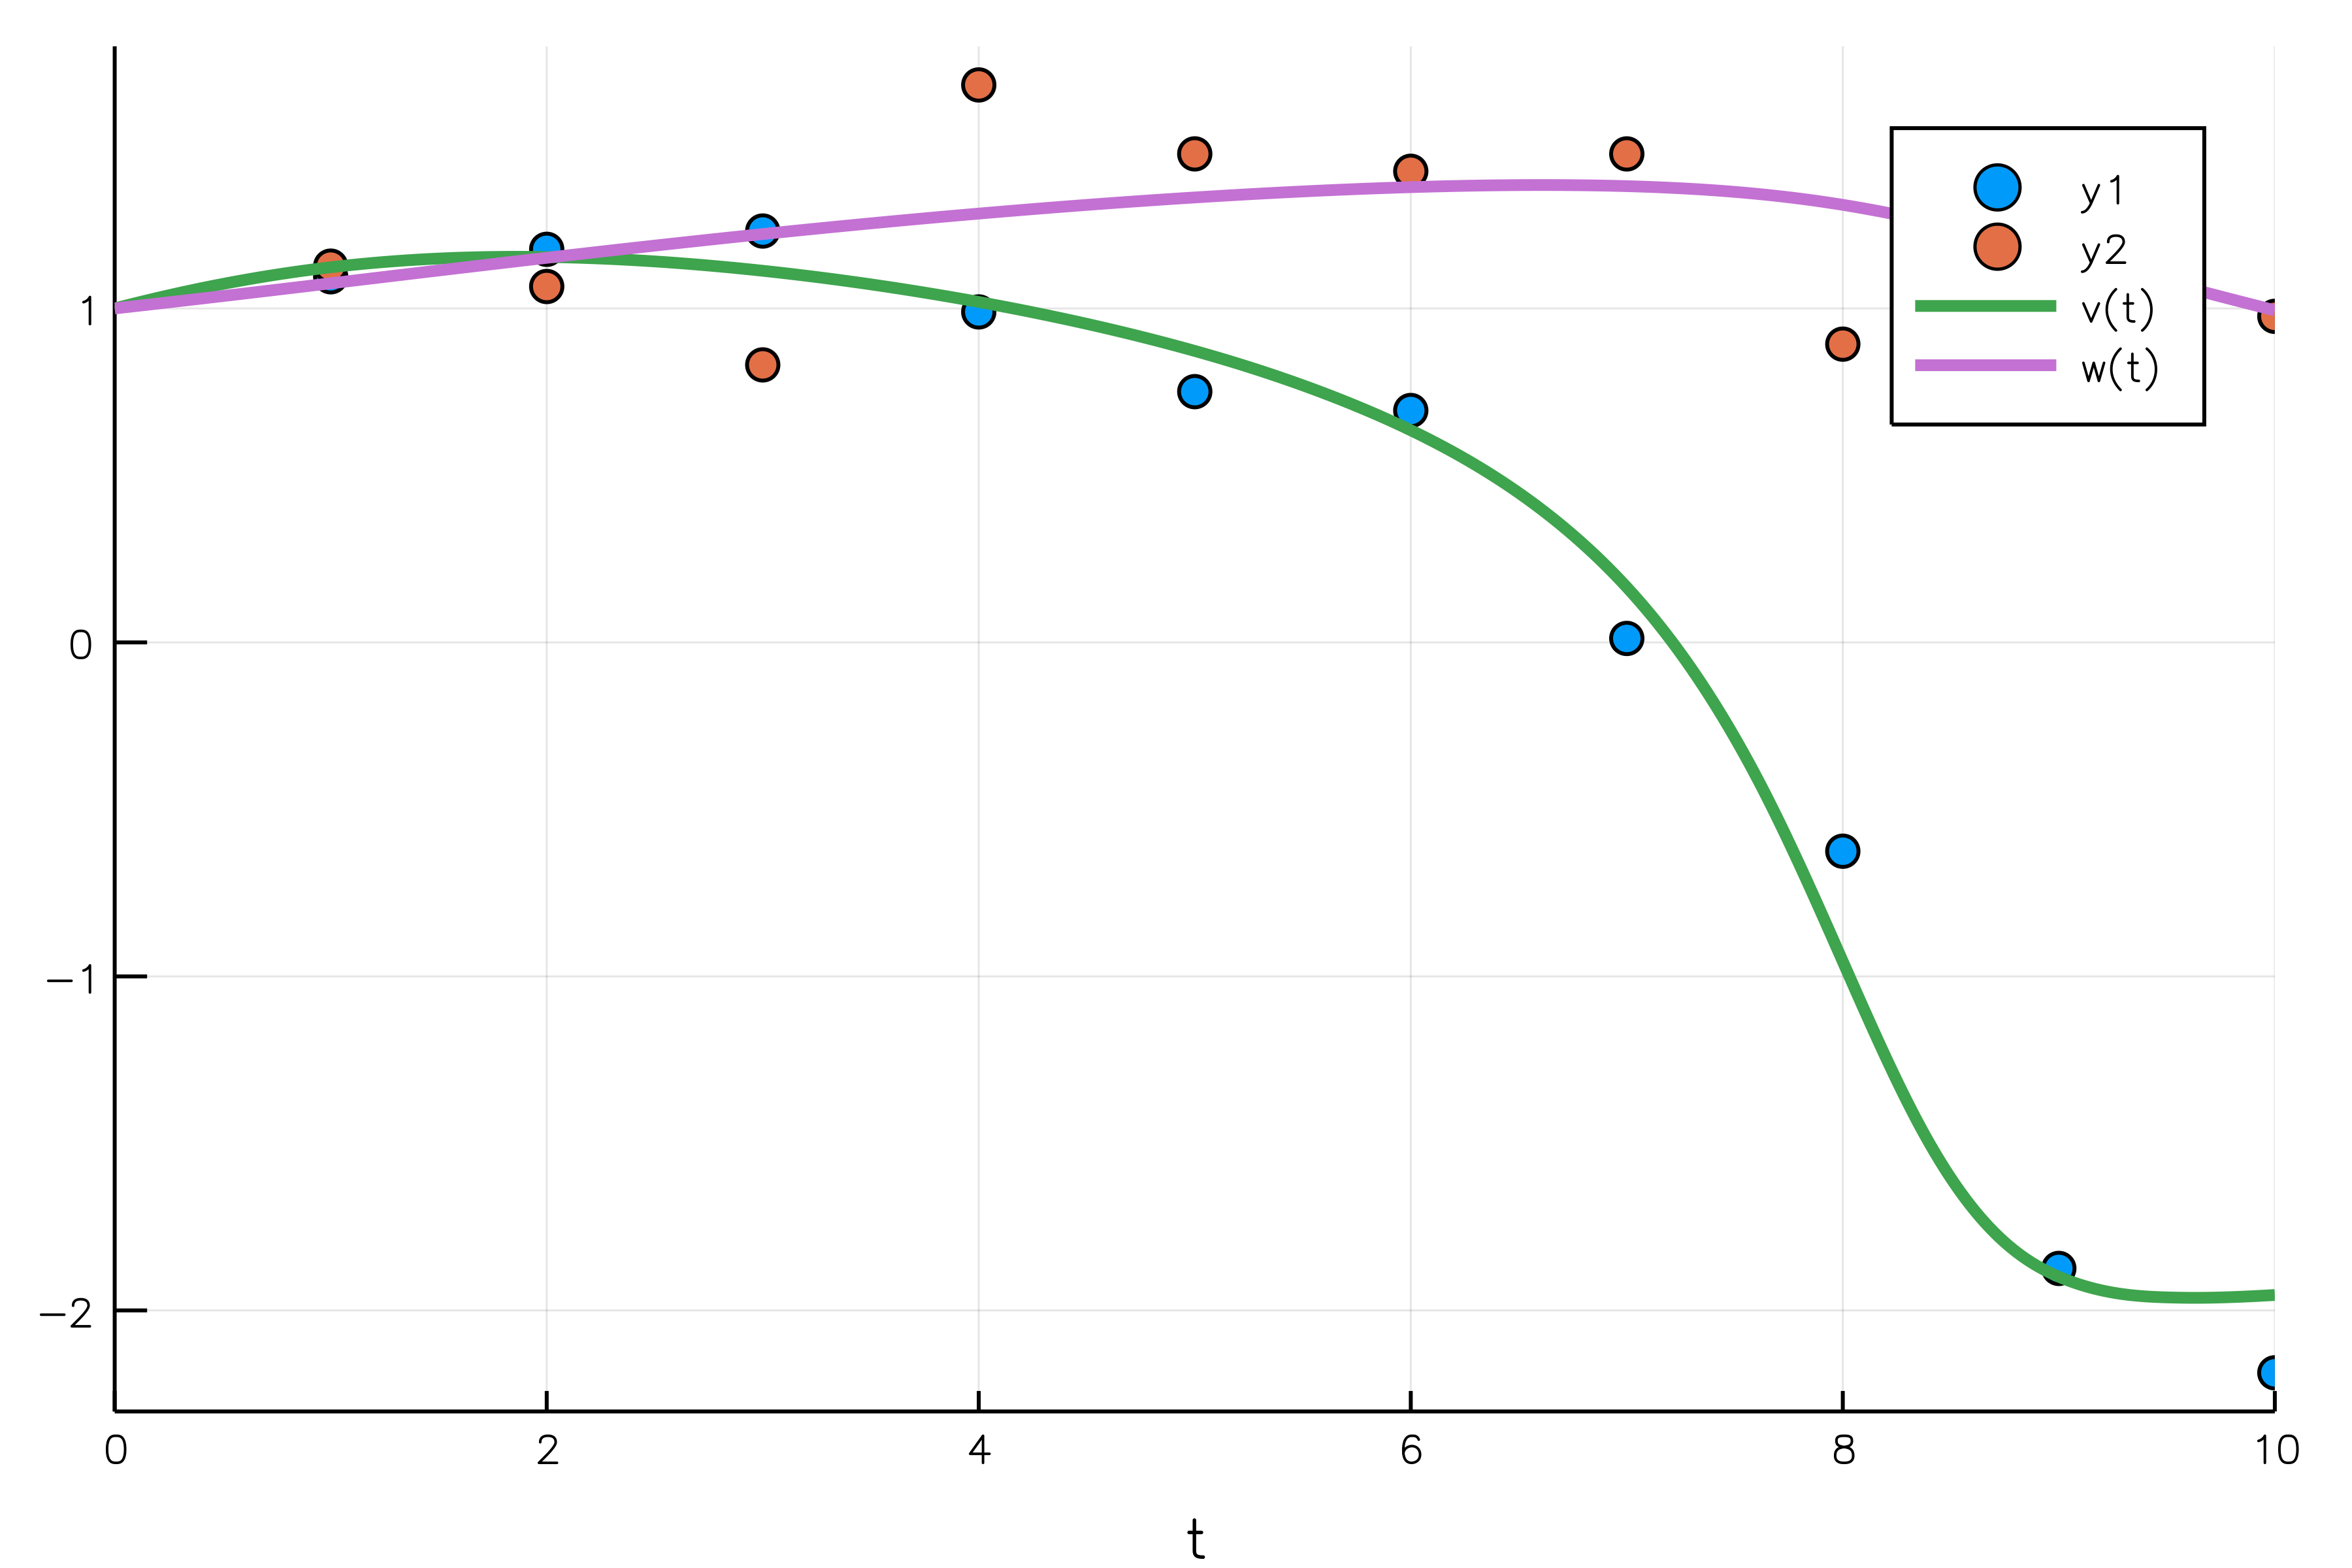

In [9]:
scatter(t, data[1,:])
scatter!(t, data[2,:])
plot!(sol)

### Priors for the parameters which will be passed for the Bayesian Inference

In [10]:
priors = [Truncated(Normal(1.0,0.5),0,1.5),Truncated(Normal(1.0,0.5),0,1.5),Truncated(Normal(0.0,0.5),-0.5,0.5),Truncated(Normal(0.5,0.5),0,1)]

4-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.5), range=(0.0, 1.5)) 
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.5), range=(0.0, 1.5)) 
 Truncated(Distributions.Normal{Float64}(μ=0.0, σ=0.5), range=(-0.5, 0.5))
 Truncated(Distributions.Normal{Float64}(μ=0.5, σ=0.5), range=(0.0, 1.0)) 

## Parameter Estimation with Stan.jl backend

In [20]:
@time bayesian_result_stan = stan_inference(prob_ode_fitzhughnagumo,t,data,priors;num_samples=100,num_warmup=500,reltol=1e-5,abstol=1e-5,vars =(StanODEData(),InverseGamma(3,2)))


File /home/vaibhav/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /home/vaibhav/tmp/parameter_estimation_model.stan --o=/home/vaibhav/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/home/vaibhav/tmp/parameter_estimation_model.stan
Output file=/home/vaibhav/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.62.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe   -lpthread  -O3 -o /home/vaibhav/tmp/parameter_estimation_model src/cmdstan/main.cpp -include /home/vaibhav/tmp/parameter_estimation_model.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-3.52217 0.979113 … 0.117683 0.549621; -2.32427 0.517205 … 0.0399687 0.42287; … ; -3.70308 0.0438356 … -0.00625557 0.276562; -2.6313 0.21177 … -0.0141743 0.277978]

[-1.8656 0.989198 … 0.0432768 0.453326; -1.56022 0.852158 … 0.044126 0.404971; … ; -4.92355 0.625777 … 0.0232483 0.423935; -3.7489 0.32234 … 0.027133 0.437429]

[-1.91307 0.839082 … 0.0763787 0.476296; -3.09687 0.980069 … 0.128032 0.533002; … ; -2.83624 0.931337 … 0.0332945 0.436312; -2.02681 0.764964 … 0.056157 0.460637]

[-3.01695 0.38301 … 0.000909014 0.280476; -4.37455 0.976377 … 0.0202513 0.29281; … ; -3.00527 0.996003 … 0.0711049 0.491658; -2.96601 0.722288 … 0.111294 0.599068])

In [21]:
Mamba.describe(bayesian_result_stan.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                  Mean         SD         Naive SE       MCSE         ESS    
         lp__ -3.57937180  2.103284267 0.10516421335  0.339120645  38.4669264
accept_stat__  0.81826185  0.247618262 0.01238091310  0.042514771  33.9223282
   stepsize__  0.04833075  0.013403769 0.00067018846  0.007728990   3.0075188
  treedepth__  5.86250000  0.889140133 0.04445700663  0.205482157  18.7237225
 n_leapfrog__ 78.82000000 38.517744503 1.92588722515 11.928975927  10.4259436
  divergent__  0.00000000  0.000000000 0.00000000000  0.000000000         NaN
     energy__  6.59543317  2.769461871 0.13847309353  0.455984405  36.8884835
     sigma1.1  0.46330437  0.111684077 0.00558420384  0.014955744  55.7656085
     sigma1.2  0.54913608  0.119484364 0.00597421819  0.006513231 100.0000000
       theta1  0.99024423  0.287358425 0.01436792123  0.015592293 100.0000000
       theta2  0.89822822  0

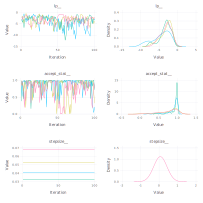

Press ENTER to draw next plot
STDIN> 


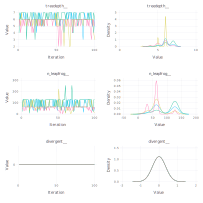

Press ENTER to draw next plot
STDIN> 


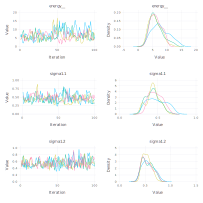

Press ENTER to draw next plot
STDIN> 


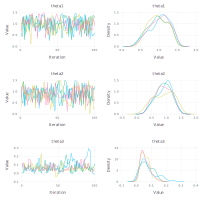

Press ENTER to draw next plot
STDIN> 


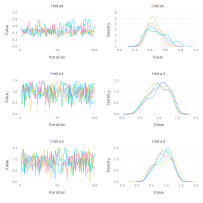

Press ENTER to draw next plot
STDIN> 


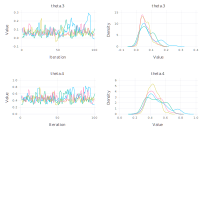

In [22]:
plot_chain(bayesian_result_stan)

## Turing.jl backend

In [8]:
@time bayesian_result_turing = turing_inference(prob_ode_fitzhughnagumo,Tsit5(),t,data,priors;num_samples=500)

[HMC] Finished with
  Running time        = 30.956978902000014;
  Accept rate         = 0.994;
  #lf / sample        = 3.992;
  #evals / sample     = 3.996;
  pre-cond. diag mat  = [1.0, 1.0, 1.0, 1.0, 1.0].
 36.322309 seconds (24.25 M allocations: 1.495 GiB, 1.86% gc time)


Object of type "Turing.Chain"

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

[0.558757 2.25128 … -43.9543 0.02; 0.557897 1.95396 … -41.5316 0.02; … ; 0.766963 0.586409 … -21.7442 0.02; 0.763077 0.598901 … -22.1449 0.02]

In [9]:
Mamba.describe(bayesian_result_turing)

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

Empirical Posterior Estimates:
             Mean                 SD                       Naive SE               MCSE        ESS    
 theta4   0.660062345 0.074099779586296279920710 0.00331384288545419477753362 0.027582837   7.2169877
      σ   0.590913661 0.245716862908609112725600 0.01098879217363293338272090 0.063725253  14.8678027
 theta2   1.100380210 0.126700798922641161281533 0.00566623198389115505235747 0.054063378   5.4922760
 theta1   0.966887642 0.132315133800616213655132 0.00591731267260315989264807 0.047763198   7.6741846
 lf_num   3.992000000 0.178885438199983204388133 0.00800000000000000016653345 0.008000000 500.0000000
elapsed   0.061922856 1.249645696786273019185387 0.05588585451608393817046760 0.057302871 475.5771996
 theta3   0.218571734 0.040155463040137090446891 0.00179580690051453798969372 0.013579631   8.7440641
     lp -22.937013493 3.629334258695910975234256 0.1623087623102572873978743

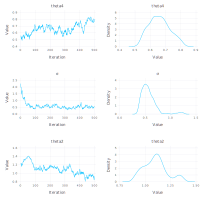

Press ENTER to draw next plot
STDIN> 


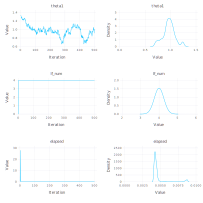

Press ENTER to draw next plot
STDIN> 


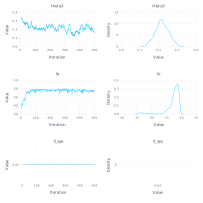

In [10]:
plot_chain(bayesian_result_turing)

## DynamicHMC.jl backend

In [22]:
@time bayesian_result_dynamic = dynamichmc_inference(prob_ode_fitzhughnagumo, data, priors, t, [bridge(ℝ, Segment(0.0,1.0)),bridge(ℝ,Segment(0.0,1.0)),bridge(ℝ, Segment(0.0,1.0)),bridge(ℝ,Segment(0.0,1.0))],ϵ=0.01,initial=[0.0,0.0,0.0,0.0])

227.722326 seconds (225.69 M allocations: 16.475 GiB, 2.81% gc time)


(([0.634314, 0.637092, 0.635419, 0.633774, 0.640803, 0.654597, 0.659265, 0.650939, 0.653558, 0.648505  …  0.732432, 0.731838, 0.734794, 0.734374, 0.729325, 0.727331, 0.727428, 0.726311, 0.725652, 0.728298], [0.867417, 0.868769, 0.867954, 0.86767, 0.867254, 0.872735, 0.874662, 0.872949, 0.873961, 0.87292  …  0.94358, 0.942465, 0.945148, 0.945474, 0.943505, 0.943026, 0.943054, 0.943804, 0.944452, 0.943998], [0.0943868, 0.094648, 0.0945976, 0.0948503, 0.0938549, 0.0934725, 0.0935483, 0.0932393, 0.0933266, 0.0939577  …  0.0912817, 0.0906136, 0.0915594, 0.0926324, 0.0930394, 0.0928995, 0.0928601, 0.0930128, 0.0931787, 0.0940555], [0.498959, 0.49953, 0.499246, 0.499272, 0.499924, 0.501847, 0.501379, 0.500371, 0.500396, 0.499957  …  0.493195, 0.49217, 0.493972, 0.49689, 0.497009, 0.495783, 0.495683, 0.495537, 0.495997, 0.499073]), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}[DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([0.550769, 1.87831, -2.26121, -0.00416508], -3332.62, 5, M

In [23]:
DynamicHMC.NUTS_statistics(bayesian_result_dynamic[2]),bayesian_result_dynamic[3],mean(bayesian_result_dynamic[1][1]),mean(bayesian_result_dynamic[1][2]),mean(bayesian_result_dynamic[1][3]),mean(bayesian_result_dynamic[1][4])

(Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.88, min/25%/median/75%/max: 0.06 0.83 0.96 0.99 1.0
  termination: MaxDepth => 87% AdjacentTurn => 8% DoubledTurn => 4%
  depth: 1 => 0% 2 => 5% 3 => 2% 4 => 4% 5 => 88%
, NUTS sampler in 4 dimensions
  stepsize (ϵ) ≈ 0.00393
  maximum depth = 5
  Gaussian kinetic energy, √diag(M⁻¹): [1.3018, 1.02203, 0.168389, 0.0939542]
, 0.6630900490983407, 0.8898288500378546, 0.09390904193500871, 0.49804807172021587)


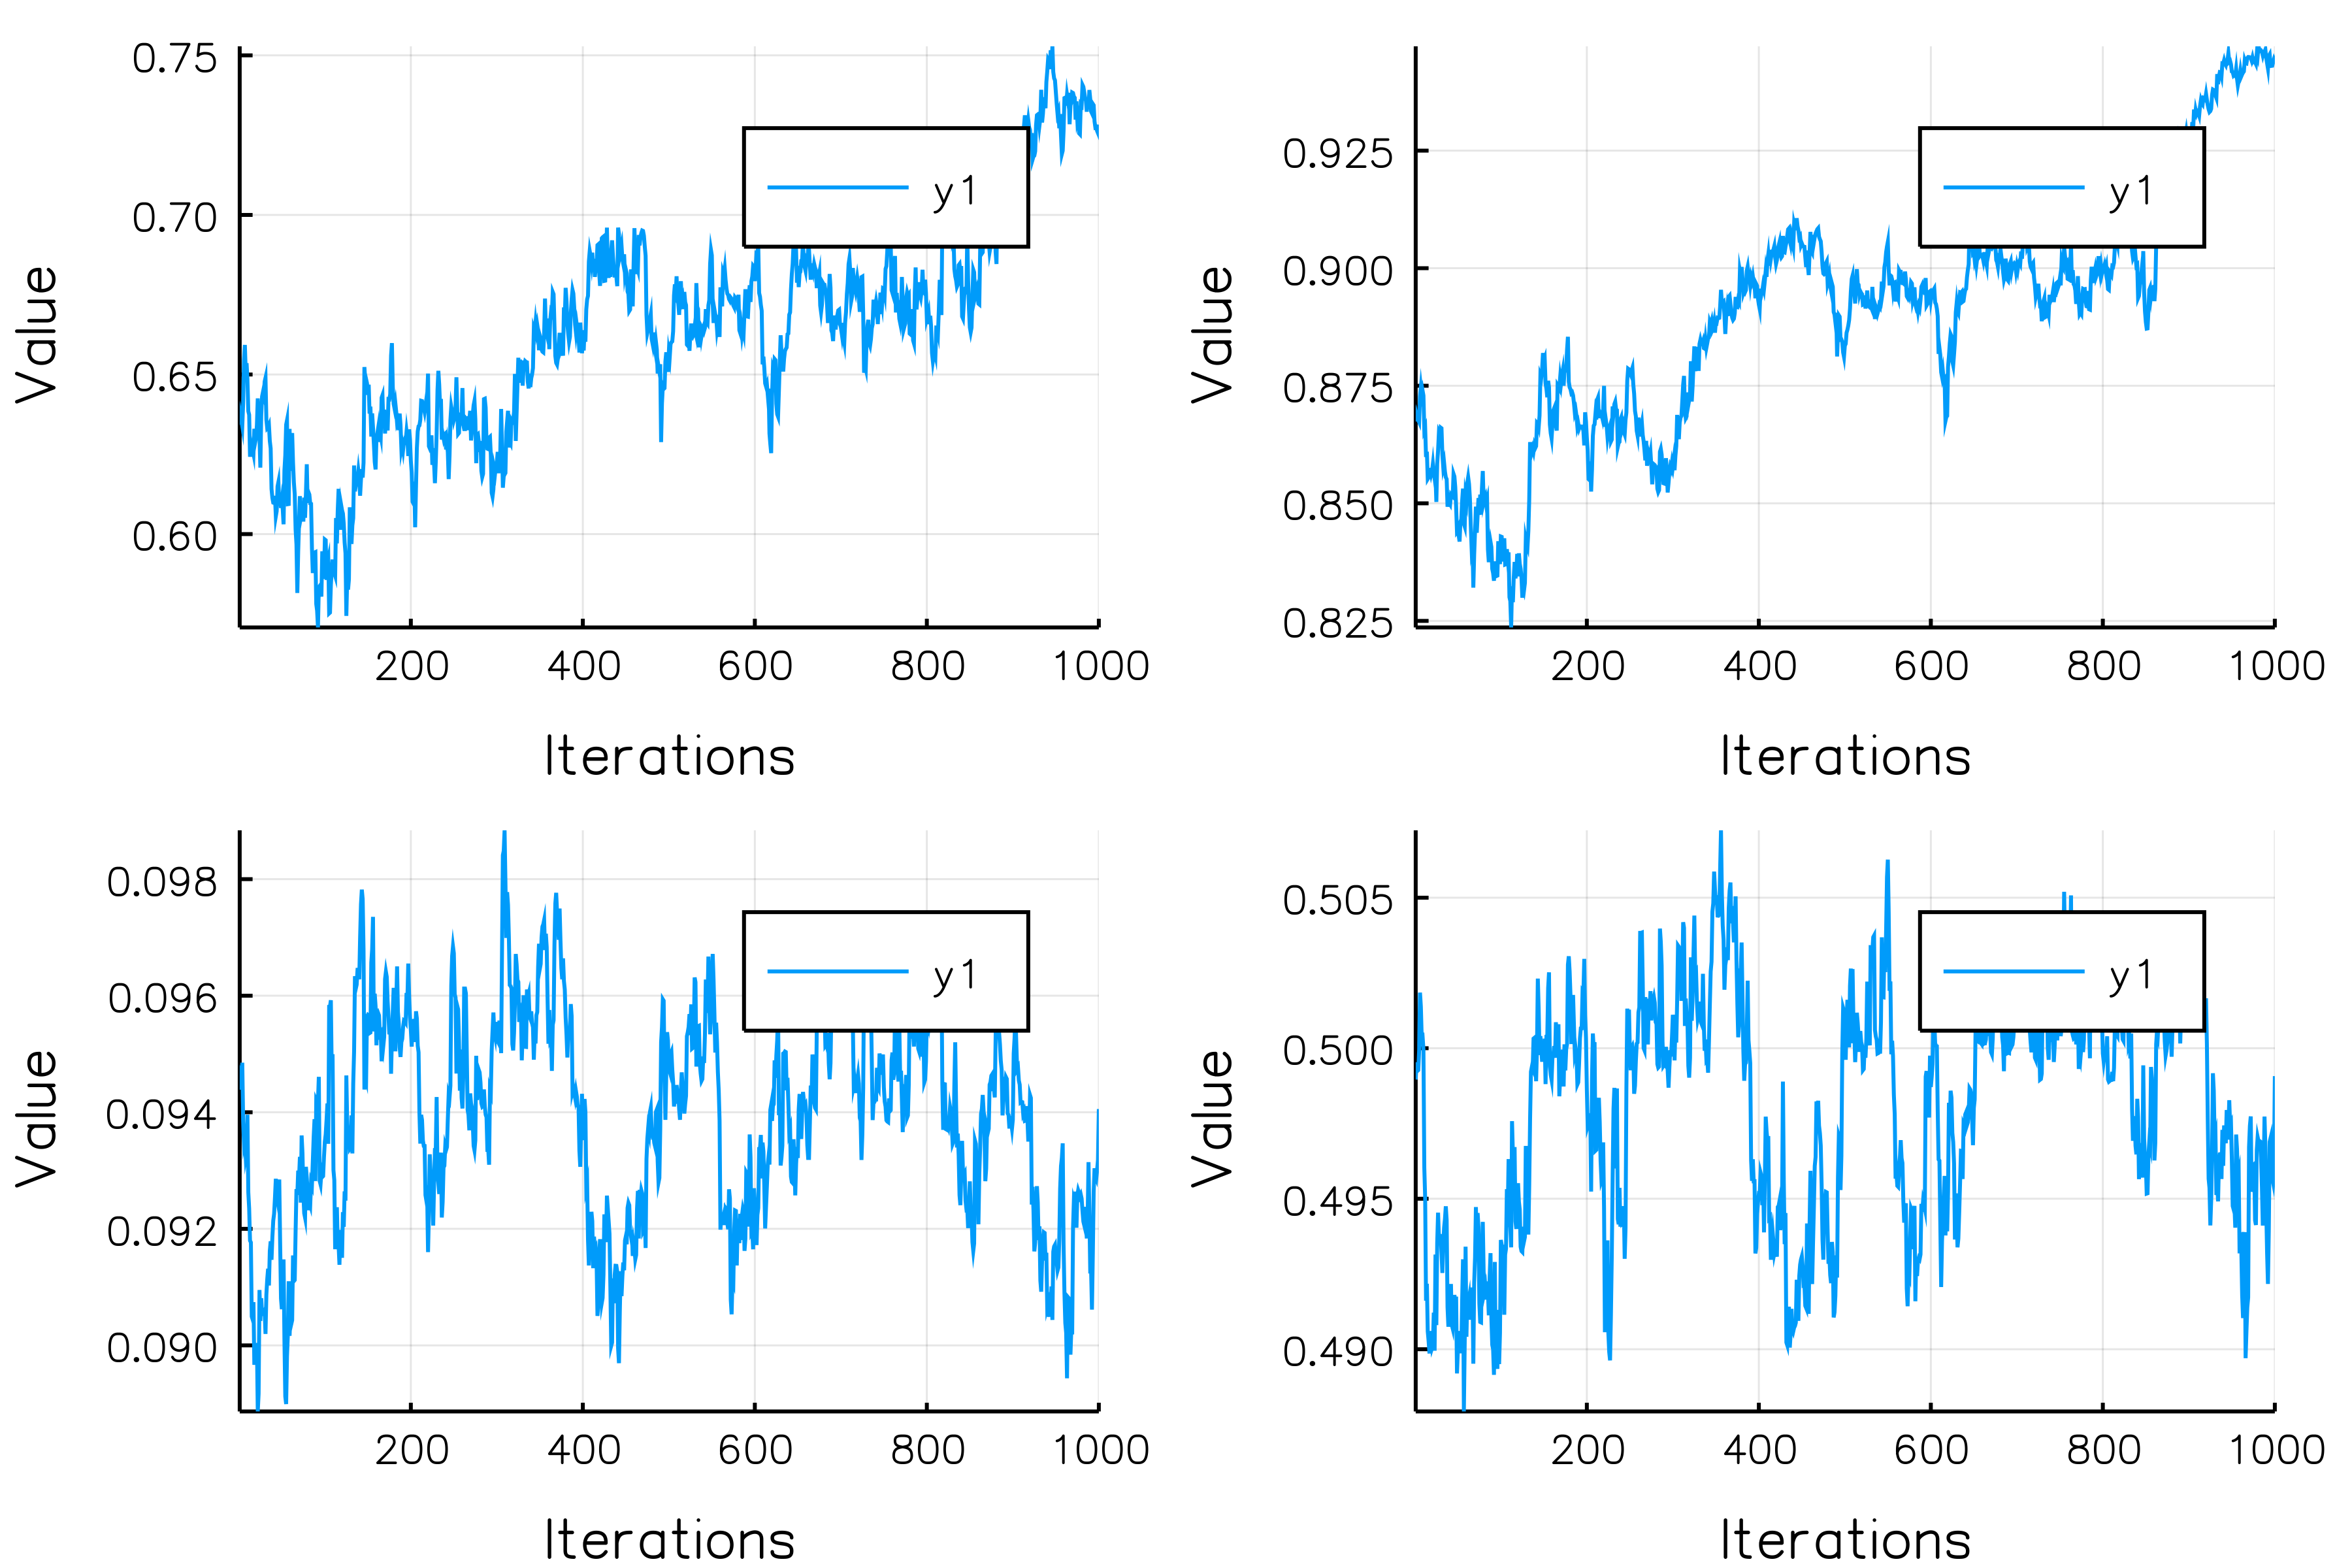

In [24]:
plot1=plot(bayesian_result_dynamic[1][1],xlab="Iterations",ylab="Value")
plot2=plot(bayesian_result_dynamic[1][2],xlab="Iterations",ylab="Value")
plot3=plot(bayesian_result_dynamic[1][3],xlab="Iterations",ylab="Value")
plot4=plot(bayesian_result_dynamic[1][4],xlab="Iterations",ylab="Value")
plot(plot1,plot2,plot3,plot4)

# Conclusion

The FitzHugh-Nagumo problem turns out to be harder than expected, we observe quite poor results accross the three backends. Accuracy can be increased by longer iterations to ensure better convergance at the cost of time efficiency. The parameters to be estimated were `[0.7,0.8,0.08,0.5]` 

Individually, Stan.jl backend takes 1.6 minutes for warmup and 12 seconds for sampling, giving `[0.99,0.90,0.07,0.46]`. Higher accuracy can be obtained with tighter priors, increase in warmup samples and adjusting the tolerance values. 

Turing.jl took just over 36 seconds and gave `[0.96,1.10,0.21,0.66]` as the result. It seems to be the most inaccurate and the trace plots indicate clear non-convergance, this can be handled by increasing the sampling size for longer iterations.

Lastly, DynamicHMC.jl backend takes 3.4 minutes and gives `[0.66, 0.88, 0.09, 0.49]`. This greater accuracy is achieved by constraints on the parameters and passing reasonable initial values. The plots indicate that more iterations would be required for convergance and this can be done by explicitly passing the length of iterations to `dynamichmc_inference`.   

Overall we observe some non-convergance in all the three backends and to avoid it longer iterations would be required at the cost of effiency the choice of which depends on the user.